In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/ericmjl/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.0-64/cuda_ndarray', '-I/home/ericmjl/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda', '-I/home/ericmjl/anaconda/lib/python3.6/site-packages/numpy/core/include', '-I/home/ericmjl/anaconda/include/python3.6m', '-I/home/ericmjl/anaconda/lib/python3.6/site-packages/theano/gof', '-o', '/home/ericmjl/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.0-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-L/home/ericmjl/anaconda/lib', '-lcublas', '-lpython3.6m', '-lcudart']


## Problem Type

Poisson regression is the kind of regression we do when we want to estimate the effect that our explanatory variables have on the dependent variable, which is of type "count data". If we're trying to find a linear combination of the explanatory variables, then our Poisson regression is a subset of generalized linear models.

It's "Poisson" mainly because we use the Poisson distribution to model the likelihood of the dependent variable.

What we get out of this type of model is the relative contribution of each explanatory variable to the value of the dependent variable.

## Data structure

To use it with this model, the data should be structured as such:

- Each row is one measurement.
- The columns should be:
    - One column per explanatory variable.
        - Use ordinal data where possible; otherwise, strictly categorical data should be binarized.
    - One column for the dependent variable.

## Extensions to the model

None.

## Reporting summarized findings

Here are examples of how to summarize the findings.

> For every increase in $X_i$, we expect to see an increase in Y by `mean` (95% HPD: [`lower`, `upper`].

## Other notes

None.

In [24]:
df = pd.read_csv('datasets/ship-damage.txt')
# Log10 transform months
df['months'] = df['months'].apply(lambda x: np.log10(x))
df['period_op'] = df['period_op'] - 1
df.head()

,type,yr_construction,period_op,months,n_damages
0,1,1,0,2.103804,0
1,1,1,1,1.799341,0
2,1,2,0,3.039414,3
3,1,2,1,3.039414,4
4,1,3,0,3.179552,6


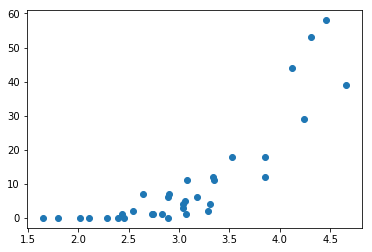

In [25]:
plt.scatter(x=df['months'], y=df['n_damages'])

In [26]:
import theano.tensor as tt

with pm.Model() as model:
    betas = pm.Normal('betas', mu=0, sd=100**2, shape=(3, 1))    
    n_damages = betas[0] * df['yr_construction'] + betas[1] * df['period_op'] + betas[2] * df['months']
    n_damages_like = pm.Poisson('likelihood', mu=np.exp(n_damages), observed=df['n_damages'])
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -197.38: 100%|██████████| 200000/200000 [00:08<00:00, 23670.40it/s]
Finished [100%]: Average ELBO = -197.39
100%|██████████| 2000/2000 [00:03<00:00, 632.37it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dcd97a630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9dbc0c9a58>]], dtype=object)

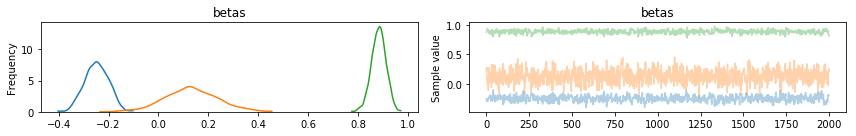

In [27]:
pm.traceplot(trace)

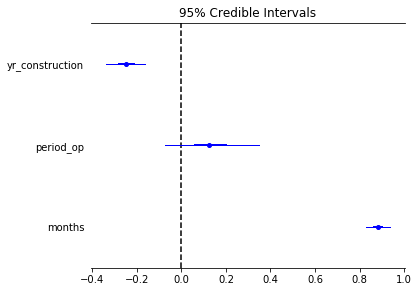

In [28]:
pm.forestplot(trace, ylabels=['yr_construction', 'period_op', 'months'])

The best interpretation of this is that the log10 number of months that a boat has been used is the strongest positive contributor to the number of damages that a ship takes.

In [18]:
pm.summary(trace)


betas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  -0.246           0.046            0.002            [-0.337, -0.157]
  ..............................[1, :]...............................
  0.124            0.102            0.004            [-0.084, 0.310]
  ..............................[2, :]...............................
  0.882            0.027            0.001            [0.826, 0.932]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  .............................[0, :].............................
  -0.340         -0.278         -0.244         -0.217         -0.157
  .............................[1, :].............................
  -0.072         0.055          0.123          0.194          0.325
  ......

In [32]:
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0, sd=100**2, shape=(3,))    
    # n_damages = betas[0] * df['yr_construction'] + betas[1] * df['period_op'] + betas[2] * df['months']
    feat_cols = ['yr_construction', 'period_op', 'months']
    n_damages = tt.dot(betas, df[feat_cols].T)
    n_damages_like = pm.Poisson('likelihood', mu=np.exp(n_damages), observed=df['n_damages'])
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -197.42: 100%|██████████| 200000/200000 [00:10<00:00, 18271.12it/s]
Finished [100%]: Average ELBO = -197.37
100%|██████████| 2000/2000 [00:03<00:00, 521.59it/s]


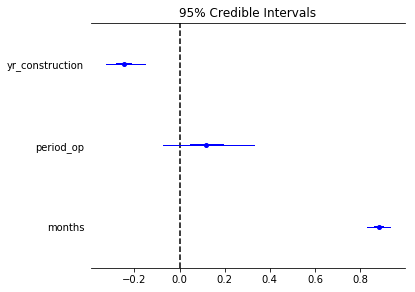

In [33]:
pm.forestplot(trace, ylabels=['yr_construction', 'period_op', 'months'])